# Keras OCR 공개구현체의 Detector(CRAFT모델) Fine-tuning 실습

이 예제에서는 본인만의 데이터셋을 사용해서, OCR 공개구현체에서 문자 위치를 찾는 Detector 기능을 Fine-tuning하는 실습을 수행합니다.

여기 예제에서는 [여기](https://rrc.cvc.uab.es/?ch=1&com=downloads)에서 다운로드 받을 수 있는 ICDAR2013 문자인식용 데이터셋으로 Fine-tuning을 수행합니다.

Copyright: https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_detector.html 의 공개구현체를 교육 목적에 맞게 수정 (2023.5.11, 김상호)

---

Keras OCR을 설치합니다.

In [1]:
import tensorflow as tf

2024-12-13 03:33:29.679149: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 03:33:29.687390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734028409.696477  115326 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734028409.699053  115326 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 03:33:29.708436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15320726552555953505
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9514565632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18314734034525750822
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1734028412.028646  115326 gpu_device.cc:2022] Created device /device:GPU:0 with 9073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


OCR 라이브러리를 비롯해 다른 필요한 라이브러리들을 설치합니다.

'data_dir' 변수는 checkpoint file을 담고 있는 폴더로 지정합니다. (google drive의 폴더 위치)

In [3]:
data_dir = '.'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

Keras에 내장된 ICDAR2013 문자인식용 데이터셋(이미지+문자 위치정보)을 읽어옵니다.

In [4]:
dataset = keras_ocr.datasets.get_icdar_2013_detector_dataset(
    cache_dir='.',
    skip_illegible=False
)

Looking for ./icdar2013/Challenge2_Training_Task12_Images.zip
Looking for ./icdar2013/Challenge2_Training_Task2_GT.zip


dataset을 인쇄해서 어떤 형태로 구성되어 있는지 분석해봅니다.

공개구현체를 이용하기 위해서는, 본인의 데이터셋(이미지+문자위치 박스 정보)을 읽어와서 분석된 dataset과 같은 형태로 가공해야 합니다.

구체적으로는, dataset 형태를 분석해서, 위의 keras_ocr 라이브러리에서 내장 데이터셋을 읽어오는 get_icdar_2013_detector_dataset()함수와 유사하게 dataset을 return해주는 새로운 함수 get_mydata_detector_dataset() 함수를 만들어야 합니다.

In [5]:
dataset

[('./icdar2013/Challenge2_Training_Task12_Images/139.jpg',
  [[(array([[  5, 142],
            [ 19, 142],
            [ 19, 166],
            [  5, 166]]),
     'E')],
   [(array([[ 41, 142],
            [ 57, 142],
            [ 57, 166],
            [ 41, 166]]),
     'R'),
    (array([[ 64, 140],
            [ 84, 140],
            [ 84, 167],
            [ 64, 167]]),
     'O'),
    (array([[ 92, 141],
            [111, 141],
            [111, 167],
            [ 92, 167]]),
     'U'),
    (array([[119, 140],
            [138, 140],
            [138, 167],
            [119, 167]]),
     'G'),
    (array([[147, 142],
            [165, 142],
            [165, 167],
            [147, 167]]),
     'H')],
   [(array([[189, 141],
            [208, 141],
            [208, 167],
            [189, 167]]),
     'G'),
    (array([[217, 142],
            [236, 142],
            [236, 168],
            [217, 168]]),
     'U'),
    (array([[245, 141],
            [250, 141],
            [250, 1

In [6]:
import zipfile
import os
def get_mydata_detector_dataset(mother_dir=None, cache_dir=None, skip_illegible=False):
  zipfile.ZipFile(cache_dir, 'r').extractall(f'{mother_dir}/extracted')
  annotation_list = os.listdir(f'{mother_dir}/extracted/mydata_detection_data/annotations')
  fin = []
  for annotation in annotation_list:
    second_element = []
    with open(f'{mother_dir}/extracted/mydata_detection_data/annotations/{annotation}', 'r') as f:
      lines = f.readline()
      f_list = lines.split(' ')
      f_list[-1] = f_list[-1].replace('"', '')

      temp = np.array(f_list[:-1], dtype=np.number).reshape(4,2)
      #print(temp)
      temp2 = (temp, f_list[-1])
      #print(temp2)
      #temp = [temp]
      second_element.append(temp2)
    second_element = [second_element]
    temp_annotation = f'{mother_dir}/extracted/mydata_detection_data/images/{annotation[:-4]}.jpg'
    fin.append((temp_annotation,second_element,1))
  return fin

In [7]:
mother_dir = '.'
cache_dir = 'mydata_detection_data.zip'
my_dataset = get_mydata_detector_dataset(mother_dir=mother_dir, cache_dir=cache_dir)

/tmp/ipykernel_115326/2038439316.py:14: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  temp = np.array(f_list[:-1], dtype=np.number).reshape(4,2)


In [8]:
my_dataset[0][1][0][0]

(array([[212., 192.],
        [326., 192.],
        [326., 249.],
        [212., 249.]]),
 'MF2Y8X')

dataset이 의도했던 포맷으로 나오는지 확인합니다.

(array([[1431,  557],
        [1582,  557],
        [1582,  687],
        [1431,  687]]),
 'M')

In [9]:
dataset

[('./icdar2013/Challenge2_Training_Task12_Images/139.jpg',
  [[(array([[  5, 142],
            [ 19, 142],
            [ 19, 166],
            [  5, 166]]),
     'E')],
   [(array([[ 41, 142],
            [ 57, 142],
            [ 57, 166],
            [ 41, 166]]),
     'R'),
    (array([[ 64, 140],
            [ 84, 140],
            [ 84, 167],
            [ 64, 167]]),
     'O'),
    (array([[ 92, 141],
            [111, 141],
            [111, 167],
            [ 92, 167]]),
     'U'),
    (array([[119, 140],
            [138, 140],
            [138, 167],
            [119, 167]]),
     'G'),
    (array([[147, 142],
            [165, 142],
            [165, 167],
            [147, 167]]),
     'H')],
   [(array([[189, 141],
            [208, 141],
            [208, 167],
            [189, 167]]),
     'G'),
    (array([[217, 142],
            [236, 142],
            [236, 168],
            [217, 168]]),
     'U'),
    (array([[245, 141],
            [250, 141],
            [250, 1

읽어온 데이터셋은 Training:Validation = 80%:20%로 분할하고, 아래의 전처리를 수행합니다. 단, Validation Images는 augmentation은 적용하지 않습니다.

1.   Augmentation (random scaling/rotation/blurring/multiplication)
2.   이미지를 640*480 사이즈로 변경

In [10]:
my_train, my_validation = sklearn.model_selection.train_test_split(
    my_dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
      scale=(1.0, 1.2),
      rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
my_training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=my_train,
    augmenter=augmenter,
    **generator_kwargs
)
my_validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=my_validation,
    **generator_kwargs
)

제대로 training용 dataset이 준비되었는지 Sanity check 목적으로, 입력 이미지중 하나를 문자위치 박스와 함께 화면에 보여줍니다.

In [11]:
next(my_training_image_generator)

(array([[[ 34,  34,  33],
         [ 61,  58,  56],
         [ 90,  86,  83],
         ...,
         [ 52,  56,  60],
         [ 42,  46,  49],
         [ 28,  33,  36]],
 
        [[ 33,  33,  32],
         [ 59,  56,  55],
         [ 84,  81,  77],
         ...,
         [ 41,  46,  42],
         [ 34,  40,  36],
         [ 27,  32,  28]],
 
        [[ 35,  35,  34],
         [ 58,  55,  53],
         [ 83,  79,  75],
         ...,
         [ 30,  33,  29],
         [ 28,  32,  28],
         [ 27,  30,  28]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [12]:
image, lines, confidence = next(my_training_image_generator)
print(lines)

[[(array([[416.5899  ,  92.16824 ],
       [460.40427 ,  89.73729 ],
       [461.60474 , 111.374016],
       [417.79037 , 113.80497 ]], dtype=float32), '853FL')]]


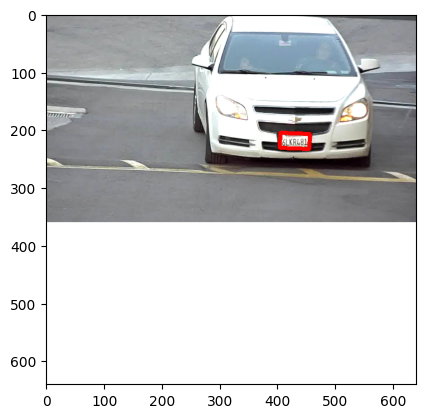

In [13]:
image, lines, confidence = next(my_training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

Detector 모델을 Keras OCR 라이브러리를 사용해서 build하는데, 이때 Detector 모델의 초기 weights는 CRAFT모델의 pre-trained weights를 자동으로 읽어옵니다.

그 후에, 1000번의 epoch동안 fine-tuning 학습을 수행하면서, 매 학습차수(epoch)마다 Keras의 callback 라이브러리를 사용하여 아래 항목들을 수행합니다.
(만일, 10번으로 나눠서 학습을 하고싶다면, epochs 숫자를 100으로 줄여서 학습을 하고, 다시 학습을 시작할 때에 h5 weights file을 Colab에 업로드하고 아래 학습을 시작하는 방식으로 이어서 학습합니다)

1.   손실함수가 줄어들지 않으면 1000번 epoch을 모두 실행하기 이전에 조기 종료시키는 early stopping (학습이 충분하게 이루어지지 않을 경우, comment처리하거나 patience값을 키움)
2.   학습 과정을 지정된 csv 파일로 기록
3.  학습된 weights를 지정된 checkpoint파일에 기록



In [14]:
detector = keras_ocr.detection.Detector()
# if any, load the detector model weights
model_weights = os.path.join(data_dir,'detector_icdar2013-2024-12-13-01-33_fin.weights.h5')
#if os.path.isfile(model_weights) == True:
detector.model.load_weights(model_weights)
print(model_weights,': loaded successfully!')

Looking for /home/kyudan/.keras-ocr/craft_mlt_25k.h5


I0000 00:00:1734028480.504867  115326 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


./detector_icdar2013-2024-12-13-01-33_fin.weights.h5 : loaded successfully!


/home/kyudan/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 190 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# 원하는 learning rate로 옵티마이저 설정 후 재-컴파일
detector.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=detector.model.loss
)

In [16]:
# Run the re-training
batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [my_training_image_generator, my_validation_image_generator]
]
detector.model.fit(
    training_generator,
    steps_per_epoch=math.ceil(len(my_train) / batch_size),
    epochs=1000,
#    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013-2024-12-13-01-33.csv')),
        tf.keras.callbacks.ModelCheckpoint(
    save_weights_only=True, 
    filepath=os.path.join(data_dir, 'detector_icdar2013-2024-12-13-01-33.weights.h5'),
    monitor='val_loss',
    save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-8
)
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(len(my_validation) / batch_size)
)

Epoch 1/1000
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


I0000 00:00:1734028518.749953  115979 service.cc:148] XLA service 0x7efb9c003790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734028518.750093  115979 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-12-13 03:35:18.909325: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734028519.707367  115979 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1734028531.459281  115979 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


177/177 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - loss: 6.6322e-05 - val_loss: 1.0333e-04 - learning_rate: 1.0000e-05
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 4.8207e-05 - val_loss: 1.4235e-04 - learning_rate: 1.0000e-05
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 4.9113e-05 - val_loss: 1.0653e-04 - learning_rate: 1.0000e-05
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 4.2461e-05 - val_loss: 9.0935e-05 - learning_rate: 1.0000e-05
Epoch 5/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 3.3578e-05 - val_loss: 7.6106e-05 - learning_rate: 1.0000e-05
Epoch 6/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 3.8282e-05 - val_loss: 7.0241e-05 - learning_rate: 1.0000e-05
Epoch 7/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 4.4192e-05 - val_loss: 1.0139e-04 - learning_rate: 1.0000e-06
Epoch 8/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 3.3256e-05 - val_loss: 8.9363e-05 - learning_rate: 1.0000e-06
Epoch

---

### 학습된 Weights로 Validation 데이터를 추론해보기

위의 100번 epoch 실행을 10번 반복 수행해서, 총 1000번 epoch만큼 학습이 완료된 'detector_mydata.h5' 파일을 Colab에 업로드해서 detection test를 수행해 봅시다.

아래 셀을 실행하면, 모든 validation 데이터셋에 대해 detection을 수행하고, 문자 위치 박스가 표시된 결과 이미지를 output_folder에 저장합니다.

학습을 몇번만 진행한 것과 충분히 학습한 Detector의 추론 성능을 아래와 같이 비교해보세요.

1. 먼저, 위에서 학습을 진행하지 않거나 몇번 epoch만 학습을 진행하고 중단한 후에, 아래의 셀을 실행해서 추론 성능을 test합니다.
2. 다음에, 1000번 학습이 완료된 weights 파일('detector.mydata.h5')을 업로드하고, 위로 돌아가서 detector를 다시 build하고, 아래의 셀을 실행해서 추론 성능을 test합니다.

In [27]:
!mkdir mydata_detection_result

mkdir: cannot create directory ‘mydata_detection_result’: File exists


In [17]:
import imageio
import cv2

output_folder = 'mydata_detection_result'

for image_path, _, _ in my_validation:
  image = keras_ocr.tools.read(image_path)

  output_image_path = os.path.join(output_folder, image_path.split('/')[-1])

  # detector prediction
  pred_boxes = detector.detect(np.expand_dims(image, axis=0))

  for each_pred in pred_boxes[0]:
    left, top = each_pred[0]
    right, bottom = each_pred[2]
    canvas = cv2.rectangle(image, (int(left), int(top)), (int(right), int(bottom)), (0,255,0), 3)

  imageio.imwrite(output_image_path, canvas)
  print(output_image_path + ' saved!' )

2024-12-13 03:39:02.782741: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 15.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
mydata_detection_result/wts-lg-000080.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
mydata_detection_result/car9.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000090.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
mydata_detection_result/car6.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000197.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000189.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000172.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000186.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000037.jpg saved!


2024-12-13 03:39:16.830396: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 11.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
mydata_detection_result/wts-lg-000022.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000048.jpg saved!


2024-12-13 03:39:21.719652: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12.90GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
mydata_detection_result/car9-2.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
mydata_detection_result/wts-lg-000139.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
mydata_detection_result/wts-lg-000098.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
mydata_detection_result/wts-lg-000088.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
mydata_detection_result/wts-lg-000010.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
mydata_detection_result/wts-lg-000087.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
mydata_detection_result/wts-lg-000094.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000101.jpg saved!


2024-12-13 03:39:26.630452: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
mydata_detection_result/us6.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
mydata_detection_result/wts-lg-000067.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000078.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
mydata_detection_result/wts-lg-000169.jpg saved!


2024-12-13 03:39:32.048669: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12.90GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
mydata_detection_result/car9-9.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
mydata_detection_result/wts-lg-000119.jpg saved!


2024-12-13 03:39:37.293359: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
mydata_detection_result/wts-lg-000043.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
mydata_detection_result/wts-lg-000084.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
mydata_detection_result/wts-lg-000190.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
mydata_detection_result/wts-lg-000106.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
mydata_detection_result/us1.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
mydata_detection_result/wts-lg-000183.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
mydata_detection_result/wts-lg-000161.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
mydata_detection_result/wts-lg-000127.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
mydata_detection_result/cfaa9dd2-a388-4e92-bb3a-ae65c28d8139.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
mydata_detection_result/wts-lg-000120.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
mydata_detection_result/wts-lg-000164.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms

2024-12-13 03:39:43.687225: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
mydata_detection_result/us7.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
mydata_detection_result/wts-lg-000035.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
mydata_detection_result/wts-lg-000160.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
mydata_detection_result/wts-lg-000195.jpg saved!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
mydata_detection_result/wts-lg-000150.jpg saved!


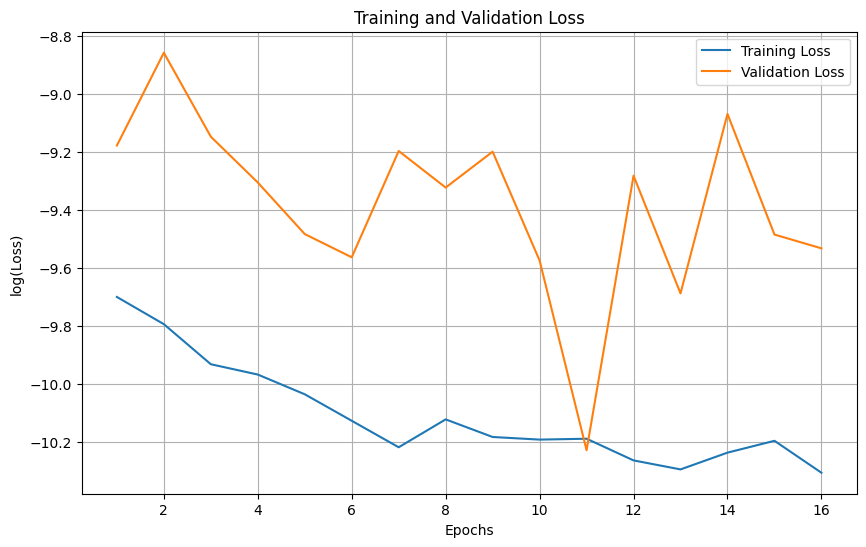

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# CSV 파일 경로
csv_path = os.path.join(data_dir, 'detector_icdar2013-2024-12-13-01-33.csv')

# CSV 파일 읽기
data = pd.read_csv(csv_path)

# Training loss와 Validation loss 데이터 가져오기
training_loss = np.log(data['loss'])
validation_loss = np.log(data['val_loss'])
epochs = range(1, len(training_loss) + 1)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('log(Loss)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
